# Dispersion Curves Visualization

This notebook visualizes dispersion curves from daily velocity data files.
It shows individual daily curves and computes median with percentiles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from scipy import stats

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Configuration
data_dir = Path('./output/velocity_data')
percentiles = [5, 25, 75, 95]  # Percentiles to compute
figsize = (12, 8)

In [3]:
# Load all CSV files
csv_files = sorted(data_dir.glob('gring_velocity_*.csv'))
print(f"Found {len(csv_files)} daily data files")

# Load all data
all_data = []
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        df['date'] = pd.to_datetime(df['day'])
        all_data.append(df)
    except Exception as e:
        print(f"Error loading {csv_file.name}: {e}")

if not all_data:
    raise ValueError("No data files found or loaded successfully")

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"Total data points: {len(combined_df)}")
print(f"Date range: {combined_df['date'].min().date()} to {combined_df['date'].max().date()}")
print(f"Frequency bands: {sorted(combined_df['fband'].unique())}")

Found 44 daily data files
Total data points: 4304
Date range: 2024-01-01 to 2024-02-29
Frequency bands: [0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794, 1.0]


In [4]:
# Group by frequency band and compute statistics
freq_stats = []

for fband in sorted(combined_df['fband'].unique()):
    freq_data = combined_df[combined_df['fband'] == fband]['velocity'].dropna()
    
    if len(freq_data) > 0:
        stats_dict = {
            'fband': fband,
            'median': np.median(freq_data),
            'mean': np.mean(freq_data),
            'std': np.std(freq_data),
            'count': len(freq_data)
        }
        
        # Add percentiles
        for p in percentiles:
            stats_dict[f'p{p}'] = np.percentile(freq_data, p)
        
        freq_stats.append(stats_dict)

stats_df = pd.DataFrame(freq_stats)
print(f"Statistics computed for {len(stats_df)} frequency bands")

Statistics computed for 11 frequency bands


## Plot 1: Individual Daily Dispersion Curves

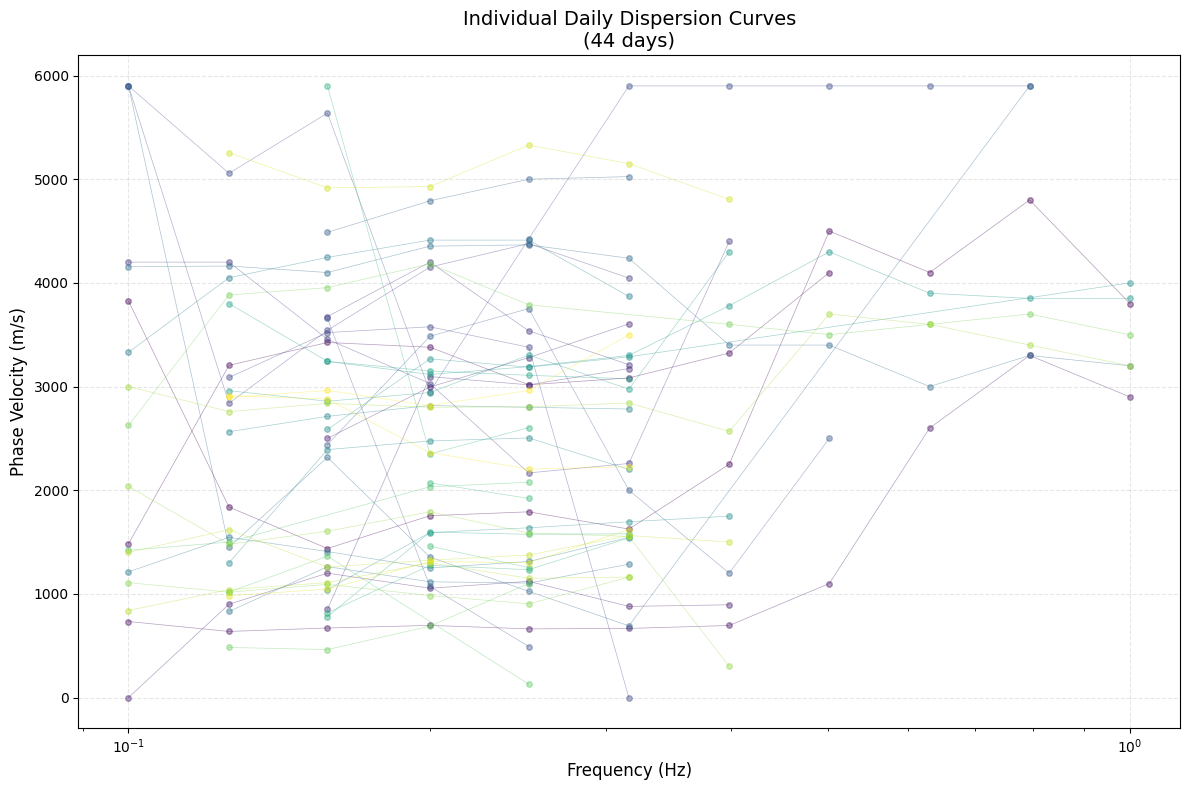

In [5]:
# Plot individual daily curves
fig, ax = plt.subplots(figsize=figsize)

# Get unique dates
unique_dates = sorted(combined_df['date'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_dates)))

for idx, date in enumerate(unique_dates):
    daily_data = combined_df[combined_df['date'] == date]
    
    # Group by frequency band and take mean velocity for each band
    daily_freq = daily_data.groupby('fband')['velocity'].mean().reset_index()
    daily_freq = daily_freq.sort_values('fband')
    
    # Plot as dots connected by lines
    ax.plot(daily_freq['fband'], daily_freq['velocity'], 
            'o-', alpha=0.4, markersize=4, linewidth=0.5, 
            color=colors[idx], label=None)

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Phase Velocity (m/s)', fontsize=12)
ax.set_title(f'Individual Daily Dispersion Curves\n({len(unique_dates)} days)', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

## Plot 2: Median with Percentile Area

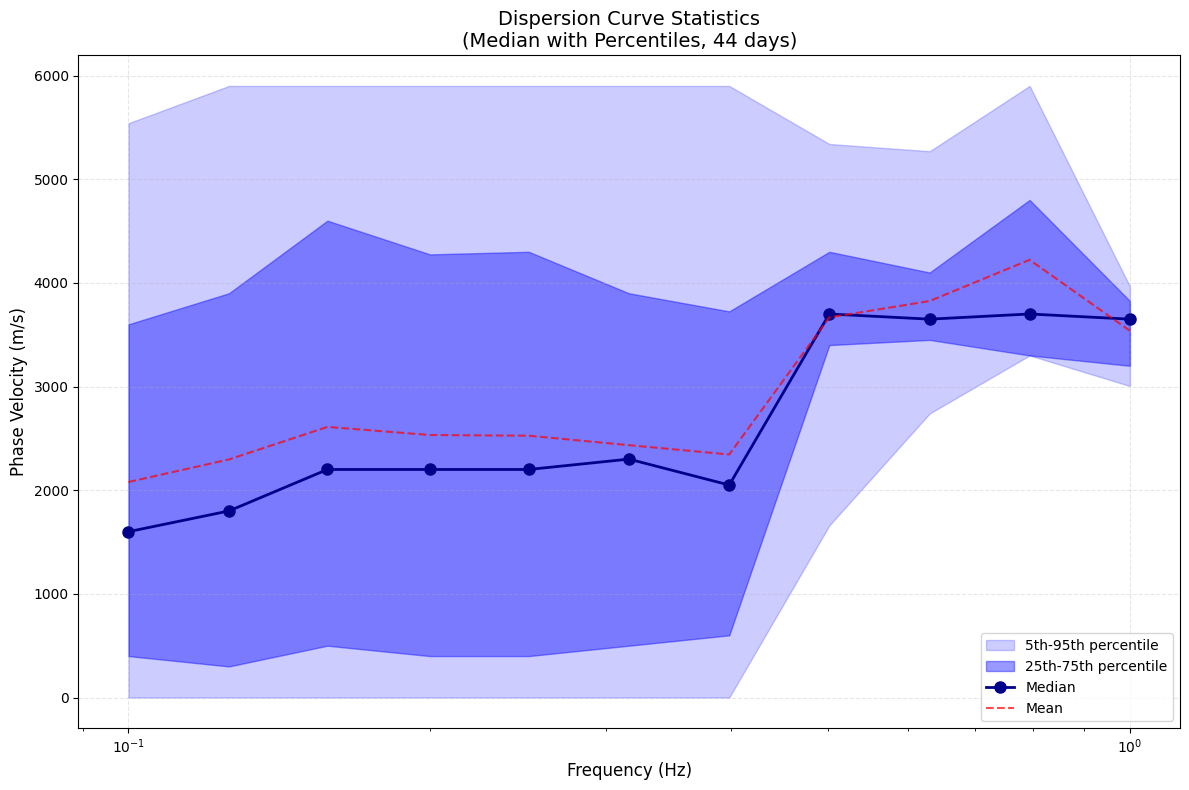

In [6]:
# Plot median with percentile area
fig, ax = plt.subplots(figsize=figsize)

# Sort by frequency
stats_df_sorted = stats_df.sort_values('fband')

# Get number of unique days for title
num_days = len(combined_df['date'].unique())

freqs = stats_df_sorted['fband'].values
median = stats_df_sorted['median'].values
p5 = stats_df_sorted['p5'].values
p25 = stats_df_sorted['p25'].values
p75 = stats_df_sorted['p75'].values
p95 = stats_df_sorted['p95'].values

# Fill between percentiles
ax.fill_between(freqs, p5, p95, alpha=0.2, color='blue', label='5th-95th percentile')
ax.fill_between(freqs, p25, p75, alpha=0.4, color='blue', label='25th-75th percentile')

# Plot median line
ax.plot(freqs, median, 'o-', color='darkblue', linewidth=2, markersize=8, label='Median')

# Optional: plot mean as dashed line
mean = stats_df_sorted['mean'].values
ax.plot(freqs, mean, '--', color='red', linewidth=1.5, alpha=0.7, label='Mean')

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Phase Velocity (m/s)', fontsize=12)
ax.set_title(f'Dispersion Curve Statistics\n(Median with Percentiles, {num_days} days)', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10)
ax.set_xscale('log')
plt.tight_layout()
plt.show()

## Summary Statistics

In [7]:
# Display summary statistics
print("\nSummary Statistics by Frequency Band:")
print("=" * 80)
print(f"{'Frequency (Hz)':<15} {'Count':<8} {'Median':<10} {'Mean':<10} {'Std':<10} {'P5-P95':<15}")
print("-" * 80)

for _, row in stats_df_sorted.iterrows():
    print(f"{row['fband']:<15.3f} {int(row['count']):<8} {row['median']:<10.1f} {row['mean']:<10.1f} "
          f"{row['std']:<10.1f} {row['p5']:.1f}-{row['p95']:.1f}")


Summary Statistics by Frequency Band:
Frequency (Hz)  Count    Median     Mean       Std        P5-P95         
--------------------------------------------------------------------------------
0.100           149      1600.0     2079.2     1815.2     0.0-5540.0
0.126           524      1800.0     2296.8     2057.3     0.0-5900.0
0.158           821      2200.0     2610.7     2194.0     0.0-5900.0
0.200           982      2200.0     2532.3     2144.9     0.0-5900.0
0.251           987      2200.0     2525.7     2136.8     0.0-5900.0
0.316           699      2300.0     2434.6     1953.2     0.0-5900.0
0.398           108      2050.0     2344.4     1861.1     0.0-5900.0
0.501           9        3700.0     3666.7     1261.4     1660.0-5340.0
0.631           8        3650.0     3825.0     918.9      2740.0-5270.0
0.794           9        3700.0     4222.2     1027.2     3300.0-5900.0
1.000           8        3650.0     3537.5     374.0      3005.0-3965.0
